### Discovery

In [1]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
from catboost import Pool, cv, CatBoostClassifier
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

Text(0, 0.5, 'Count')

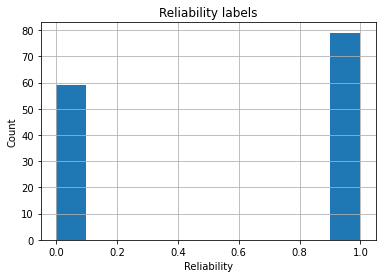

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('politifact_seo_attributes.csv')
# load labels
df_labels = pd.read_csv('domains.csv')

df_filtered = df.copy()#[df['label'].isin([1,3])]r
df_filtered.reset_index(drop=True, inplace=True)
# df_filtered.loc[df_filtered["label"] == 1, "label"] = 2 # FOR GRAPHING
# df_filtered['label']
fig, ax = plt.subplots()
df_labels.hist(column=' fake',ax = ax, align='mid')
# fig.suptitle('Reliability labels')
ax.set_title('Reliability labels')
ax.set_xlabel('Reliability')
ax.set_ylabel('Count')



In [3]:
def get_misinfo(ls_outlinks, news_clf, misinfo_clf, bias_clf):
    # ls_outlinks['is_news'] = news_clf.predict(ls_outlinks.drop(columns='url'))
    ls_outlinks['is_news'] = np.logical_or(news_clf.predict(ls_outlinks.drop(columns='url')),ls_outlinks['url'].str.contains('news')==True)

    # print(ls_outlinks.groupby('is_news').describe())
    ls_outlinks['is_misinfo'] = misinfo_clf.predict(ls_outlinks.drop(columns=['url','is_news']))
    # print(ls_news_df.groupby('is_misinfo').describe())
    ls_outlinks['is_biased'] = bias_clf.predict(ls_outlinks.drop(columns=['url','is_news','is_misinfo']))
    return ls_outlinks[['url','is_news','is_misinfo','is_biased']] # [ls_news_df['is_misinfo']==1]

news_clf = CatBoostClassifier().load_model('../flat_models/model_news_10k_mbfc')
misinfo_clf = CatBoostClassifier().load_model('../flat_models/model_misinfo_mbfc')
bias_clf = CatBoostClassifier().load_model('../flat_models/model_bias_mbfc')

ls_outlinks = pd.read_csv('data/discovered_seo_attributes.csv')
test_df = get_misinfo(ls_outlinks, news_clf, misinfo_clf, bias_clf, )#,'../data/ls_outlinks.csv')#'common_crawl_small_sample.csv')
# test_df.to_csv('data/discovered_misinfo_domains.csv', index=False)
discovered_misinfo = test_df.query('is_news == 1 & is_misinfo == 1 & is_biased == 1')
discovered_misinfo.describe()

,is_misinfo,is_biased
count,2198.0,2198.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [9]:
def compute_partial_f1(actual_domains, predicted_domains):
    # Calculate partial true positive (pTP)
    pTP = len(set(predicted_domains) & set(actual_domains))
    
    # Calculate partial false positive (pFP)
    pFP = len(set(predicted_domains) - set(actual_domains))
    
    # Calculate partial false negative (pFN)
    pFN = len(set(actual_domains) - set(predicted_domains))
    
    # Calculate partial precision (pP)
    if pTP + pFP > 0:
        pP = pTP / (pTP + pFP)
    else:
        pP = 0.0
    
    # Calculate partial recall (pR)
    if pTP + pFN > 0:
        pR = pTP / (pTP + pFN)
    else:
        pR = 0.0
    
    # Calculate partial F1 score (pF1)
    if pP + pR > 0:
        pF1 = 2 * ((pP * pR) / (pP + pR))
    else:
        pF1 = 0.0
    
    return {'Partial F1': pF1, 'Partial Precision':pP, 'Partial Recall': pR}

df_mbfc = pd.read_csv('../data/ahrefs/filtered_labels.csv')
df_mbfc = df_mbfc[df_mbfc['source'].str.contains('MBFC')]
df_mbfc = df_mbfc[df_mbfc['label']<=4]
compute_partial_f1(df_mbfc['url'], discovered_misinfo['url'])

{'Partial F1': 0.2323170731707317,
 'Partial Precision': 0.17333939945404914,
 'Partial Recall': 0.3521256931608133}

In [8]:
# alpha beta experiment

import pandas as pd

def get_link_schemes(df, domain_count, link_count):
    link_count_dict = df.groupby('domain_from')['links'].sum().to_dict()
    domain_count_dict = df.groupby('domain_from')['domain_to'].count().to_dict()


    domain_subset = set(df['domain_from'])
    domain_subset = [domain for domain in domain_subset if link_count_dict[domain] >= link_count 
                     and domain_count_dict[domain] >= domain_count]
    
    return domain_subset

def get_outlink_attributes(domain_list, edges_df, attributes_df, N):
    filtered_edges = pd.DataFrame()
    
    for domain_from in domain_list:
        # Filter the edges DataFrame based on the domain_from
        domain_edges = edges_df[edges_df['domain_from'] == domain_from].head(N)
        filtered_edges = pd.concat([filtered_edges, domain_edges])
    
    # Get unique domain_to values from the filtered edges DataFrame
    domain_to_list = filtered_edges['domain_to'].unique()
    
    # Filter the attributes DataFrame based on the domain_to_list
    filtered_attributes = attributes_df[attributes_df['url'].isin(domain_to_list)]
    
    return filtered_attributes


df_backlinks = pd.read_csv('data/politifact_link_schemes.csv')
df_backlinks.dropna(inplace=True)
df_outlinks = pd.read_csv('data/politifact_outlinks.csv')
df_attributes = pd.read_csv('data/discovered_seo_attributes.csv')
res_name = 'results/outlink_target.csv'
pd.set_option('mode.chained_assignment', None)

results = {}
print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('domains', 'links', 'outlinks', 'F1', 'P', 'R'))
for domain_count in range(1,11,1):
    link_count = 2500
    # for link_count in range(1000, 5001, 500):#np.logspace(3, 5, 10):#
    link_schemes = get_link_schemes(df_backlinks, domain_count, link_count)
    for outlink_count in range(10, 101, 10):
        outlink_attrs = get_outlink_attributes(link_schemes, df_outlinks, df_attributes, outlink_count)
        discovery_label_df = get_misinfo(outlink_attrs, news_clf, misinfo_clf, bias_clf, )
        misinfo_domains = discovery_label_df.query('is_news == 1 & is_misinfo == 1 & is_biased == 1')['url']
        res = compute_partial_f1(df_mbfc['url'], misinfo_domains)
        results[(domain_count, link_count, outlink_count)] = res
        print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(domain_count, round(link_count, 0), outlink_count, 
            round(res['Partial F1'], 2), round(res['Partial Precision'], 2), round(res['Partial Recall'], 2)))

res_df = pd.DataFrame.from_dict(results,orient='index')
res_df.reset_index(inplace=True)
res_df.columns = ['domains', 'links', 'outlinks', 'F1', 'P', 'R']
# res_df.to_csv(res_name, index=False)

domains    links      outlinks   F1         P          R         
1          2500       10         0.15       0.39       0.09      
1          2500       20         0.21       0.33       0.15      
1          2500       30         0.23       0.29       0.19      
1          2500       40         0.24       0.26       0.21      
1          2500       50         0.24       0.25       0.24      
1          2500       60         0.24       0.23       0.26      
1          2500       70         0.25       0.23       0.29      
1          2500       80         0.25       0.22       0.31      
1          2500       90         0.25       0.21       0.32      
1          2500       100        0.25       0.2        0.33      
2          2500       10         0.15       0.39       0.09      
2          2500       20         0.21       0.33       0.15      
2          2500       30         0.23       0.29       0.19      
2          2500       40         0.24       0.26       0.21      
2         

In [27]:
domain_count = 3
link_count = 2500
outlink_count = 100

link_schemes = get_link_schemes(df_backlinks, domain_count, link_count)
outlink_attrs = get_outlink_attributes(link_schemes, df_outlinks, df_attributes, outlink_count)
discovery_label_df = get_misinfo(outlink_attrs, news_clf, misinfo_clf, bias_clf, )
misinfo_domains = discovery_label_df.query('is_news == 1 & is_misinfo == 1 & is_biased == 1')['url']
res = compute_partial_f1(df_mbfc['url'], misinfo_domains)
results[(domain_count, link_count, outlink_count)] = res
print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(domain_count, round(link_count, 0), outlink_count, 
    round(res['Partial F1'], 2), round(res['Partial Precision'], 2), round(res['Partial Recall'], 2)))

3          2500       100        0.27       0.24       0.31      


In [28]:
discovery_label_df.groupby(['is_news','is_misinfo','is_biased' ]).describe()

url                                
                             count unique                 top freq
is_news is_misinfo is_biased                                      
False   0          0           135    135           flote.app    1
                   1            72     72        vpostrel.com    1
        1          0           151    151       kausfiles.com    1
                   1          1266   1266       gertzfile.com    1
True    0          0          1223   1223         nytimes.com    1
                   1           162    162  nationalreview.com    1
        1          0           326    326             cnn.com    1
                   1          1392   1392        townhall.com    1

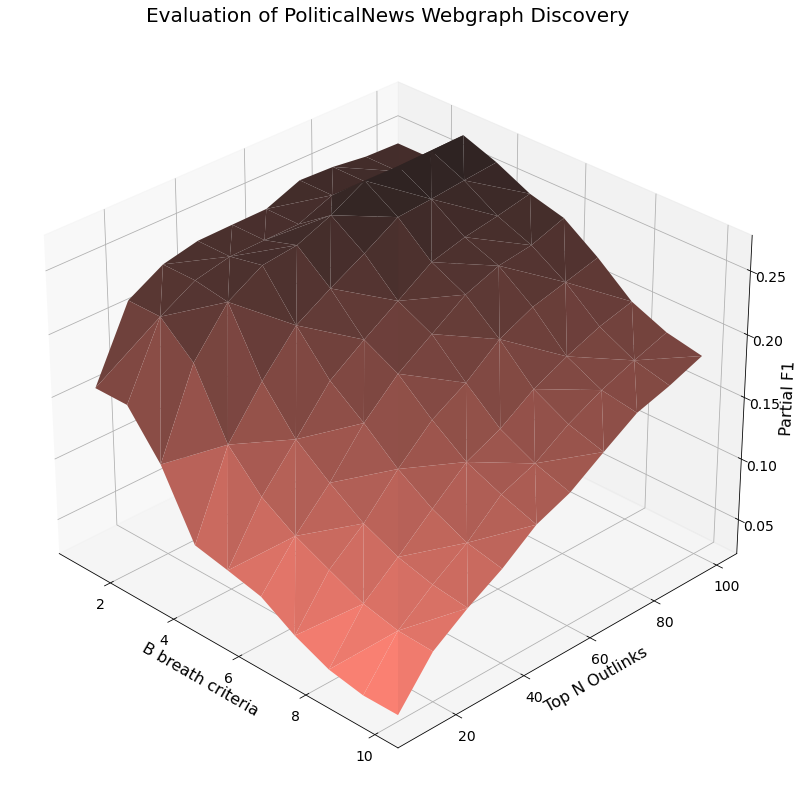

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming you have a DataFrame named df with columns: domains, links, f1
# Prepare the data
x = res_df['domains']
y = res_df['outlinks']
z = res_df['F1']
axis = 'Partial F1'
name = 'Evaluation of PoliticalNews Webgraph Discovery'
# Create a figure and a 3D axis
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
cmap = sns.color_palette("dark:salmon_r", as_cmap=True)

# Plot the surface
ax.plot_trisurf(x, y, z, cmap=cmap, edgecolor='none')


# Set labels and title
ax.set_xlabel('\u0392 breath criteria', fontsize=16)
ax.set_ylabel('Top N Outlinks', fontsize=16)
ax.set_zlabel(axis, fontsize=16)
ax.set_title(name, fontsize=20)
ax.view_init(elev=30, azim=-45)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)
# Show the plot
plt.savefig('../results/fig/link_scheme_evaluation_outlinks_reduced.png', bbox_inches='tight', dpi=300)


In [30]:
len(z)

100

In [31]:
bl_count_df = pd.read_csv('results/full.csv')
bl_count_df = bl_count_df[bl_count_df['domains'] < 3]
bl_count_df = bl_count_df[bl_count_df['links'] ]
bl_count_df.groupby('outlinks').mean()[['F1']].plot()

KeyError: "None of [Int64Index([ 50000,  50000,  50000,  50000,  50000,  50000,  50000,  50000,\n             50000,  50000, 100000, 100000, 100000, 100000, 100000, 100000,\n            100000, 100000, 100000, 100000, 150000, 150000, 150000, 150000,\n            150000, 150000, 150000, 150000, 150000, 150000, 200000, 200000,\n            200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000,\n            250000, 250000, 250000, 250000, 250000, 250000, 250000, 250000,\n            250000, 250000, 300000, 300000, 300000, 300000, 300000, 300000,\n            300000, 300000, 300000, 300000, 350000, 350000, 350000, 350000,\n            350000, 350000, 350000, 350000, 350000, 350000, 400000, 400000,\n            400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000],\n           dtype='int64')] are in the [columns]"